In [6]:
import math, pickle, glob, yaml
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.linewidth'] = 0.8

save = False
saveformat = '.png' # or ''
dpi = 600
paramtitle = False

In [26]:
one_label_one_data = False
workspace = 'noisy'
label     = 'noisy_normal2'
figlabel = workspace

label_dir = '../data/{}/{}/'.format(workspace,label)
wild_dir  = '../data/{}/{}/*.pickle'.format(workspace,label)

list_for_lpwise_dicts = []

count = 0

label_list = glob.glob(label_dir)
for label in label_list:
    data_list = glob.glob(label+'*.pickle')
    for data_path in data_list:
        with open(data_path, 'rb') as f:
            hyperdict  = pickle.load(f)
            lpwise_dict = pickle.load(f)
            list_for_lpwise_dicts.append((hyperdict, lpwise_dict))
            count += 1 
        if one_label_one_data:
            break
    
print('{} data were loaded.'.format(count))

algo = hyperdict['algo']
T, T_save, loop, k, p = hyperdict['T'], hyperdict['T_save'] ,hyperdict['loop'], hyperdict['k'], hyperdict['p']
sigma, delta = hyperdict['sigma'], hyperdict['delta']
learning_param_list = np.asarray(hyperdict['lp_list'])

if algo == 'noisy':
    noisy_lpwise_dicts = list_for_lpwise_dicts
    noisy_param_list   = learning_param_list
elif algo == 'oja':
    oja_lpwise_dicts = list_for_lpwise_dicts
    oja_param_list   = learning_param_list
else:
    raise NotImplementedError

print('Hyper Dictionary Sample: ')
for k,v in hyperdict.items():
    print('{}: {}'.format(k,v))

12 data were loaded.
Hyper Dictionary Sample: 
T: 144000
T_save: 100
loop: 3
k: 5
p: 100
sigma: 0.15
gamma: 3e-06
delta: 1.0
algo: noisy
lp_list: [   2    3    8   10   20   30   40   60   80  100  200  300  400  600
  800 1000 1200 1500 1800 2000 3000 4000 6000 8000 9600]
label: noisy_normal2
rotate_type: True


## Data Selection

In [60]:
### Data selection ###
algorithm = 'oja'

# for noisy
target_p     = 100
target_delta = None
target_gammathres = None

if algorithm == 'noisy':
    list_for_lpwise_dicts = noisy_lpwise_dicts
elif algorithm == 'oja':
    list_for_lpwise_dicts = oja_lpwise_dicts        
else:
    raise NotImplementedError
    
except_idxs = []
for idx, (hyperdict, lpwise_dict) in enumerate(list_for_lpwise_dicts):
    
    if (target_delta != None):
        if not math.isclose(hyperdict['delta'],target_delta): except_idxs.append(idx)
    
    if (target_gammathres != None):
        if hyperdict['gamma'] > target_gammathres:
            except_idxs.append(idx)
            
    if (target_p     != None):
        if not math.isclose(hyperdict['p'],target_p): except_idxs.append(idx)

target_list = [v for idx, v in enumerate(list_for_lpwise_dicts) if not idx in except_idxs]
print('total data #:',len(target_list))

total data #: 12


## Plotting

label=$\Gamma=0e+00$, min=0.012304592247724478
label=$\Gamma=1e-05$, min=0.031277633072844084
label=$\Gamma=2e-05$, min=0.04016262165122083
label=$\Gamma=3e-05$, min=0.044496860289394265
label=$\Gamma=4e-05$, min=0.05118867655106681
label=$\Gamma=5e-05$, min=0.05263188555912696
label=$\Gamma=6e-05$, min=0.05716222639972529
label=$\Gamma=7e-05$, min=0.0613897232137632
label=$\Gamma=8e-05$, min=0.06405090371266124
label=$\Gamma=9e-05$, min=0.06525656714029815
label=$\Gamma=1e-04$, min=0.06891893470697119


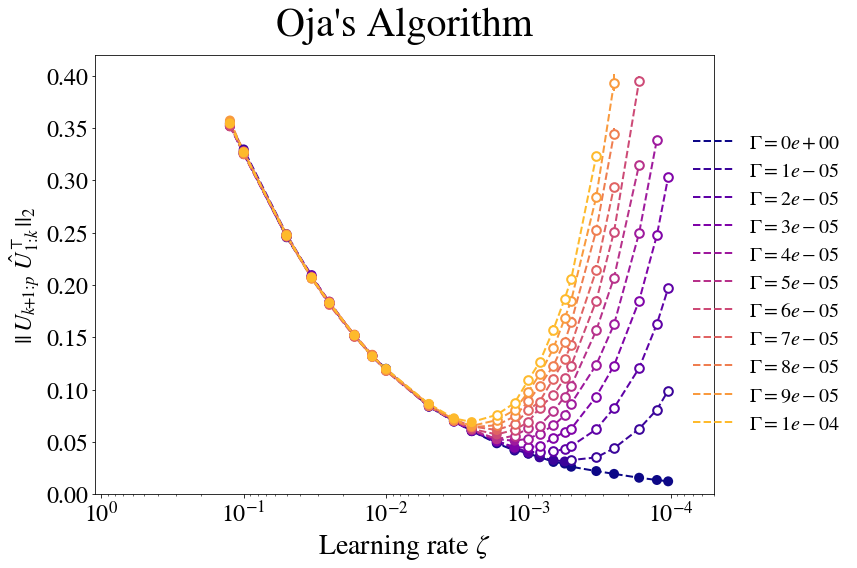

In [246]:
# Sort target_list
target_list = sorted(target_list, key=lambda v: (v[0]['p'],-v[0]['delta'],v[0]['gamma'],v[0]['k']))

# Basic settings
ub = 0.4
trim = True
sparselabel = False #0, 3, 7... 만 label 부여
save = True

fig = plt.figure(figsize=(12,8),facecolor=(1, 1, 1)) #(12,8)

if algorithm=='noisy':
    colors = pl.cm.viridis(np.linspace(0,0.8,len(target_list)))
elif algorithm=='oja':
    colors = pl.cm.plasma(np.linspace(0,0.85,len(target_list)))
    
else:
    raise NotImplementedError

# Main
for c, (hyperdict, datadict_list) in enumerate(target_list):
    
    if algorithm=='noisy':
        lp_xaxis = np.copy(noisy_param_list)#[1:-3]
    elif algorithm=='oja':
        lp_xaxis = np.copy(oja_param_list)#[:-2]
        #lp_xaxis = np.flip(lp_xaxis)

    # Extract Data
    dist_array = np.zeros((loop,len(lp_xaxis)))    
    for repeat,datadict in enumerate(datadict_list):

        for lp_idx,lp in enumerate(lp_xaxis):
            if algorithm == 'oja':
                dist_array[repeat,lp_idx] = np.average(datadict[lp][-30:])  
            else:
                dist_array[repeat,lp_idx] = np.average(datadict[lp][len(datadict[lp])//3:])
    
    #dist_array = np.flip(dist_array,axis=1) if algo=='oja' else dist_array
    
    # Set Label
    #label_str = r'$(\Gamma,\delta,p)=({:.0e},{:.1f},{})$'.format(hyperdict['gamma'],hyperdict['delta'],hyperdict['p'])
    label_str = r'$\Gamma={:.0e}$'.format(hyperdict['gamma'])
        
    avg = np.average(dist_array,axis=0)
    std = np.std(dist_array,axis=0)
    
    print('label={}, min={}'.format(label_str,np.min(avg)))
    
    # Trim unconverged data
    
    if trim:
        if np.where(avg<ub)[0].size != 0:
            args = np.where(avg<ub)[0]
            #print(args)
            lp_xaxis = lp_xaxis[args]
            avg, std = avg[args], std[args]
        
    # Plot line
    if sparselabel:
        label_str = label_str if c%4==1 else '_nolegend_'
    
    plt.plot(lp_xaxis,avg,ls='--',linewidth=2,color=colors[c],label=label_str,zorder=1)
    plt.errorbar(lp_xaxis,avg,std,fmt='none', ecolor=colors[c],elinewidth=2,capsize=0,zorder=2)
    
    # Plot marker 
    signlist = np.ones(len(lp_xaxis))
    arg = np.argmin(avg)
    
    signlist[arg+1:] = -1
    for jdx, sign in enumerate(signlist):
        marker_s = ('o',100) if sign==1 else ('o',75)
        color_s   = ('none',colors[c]) if sign==1 else (colors[c],'white')
        plt.scatter(lp_xaxis[jdx],avg[jdx],marker=marker_s[0],s=marker_s[1],\
                    color=color_s[1],edgecolors=color_s[0],linewidths=2,zorder=3) 

# Title
algoname = 'Oja\'s Algorithm' if algorithm=='oja' else 'Noisy Power Method'
if paramtitle:
    title = algoname + r', $(\delta,\,\sigma,\,p/k)=({:.1f},\,{:.2f},\,{:d})$'.format(delta, sigma, p//k)
    titlesize = 28
else:
    title = algoname
    titlesize = 40
plt.title(title,fontsize=titlesize,pad=20)

# Other plotting details

# for 'npm_k2_noisy'
if algorithm=='noisy':
    plt.xlabel(r'Block Size $B$',fontsize=28,labelpad=5)
    plt.xlim(10,20000) # -500, 10000
    plt.ylim(0.00,ub*1.05)  # 0.00, 1.1
    plt.xticks([100,1000,3000,5000,7000,10000],fontsize=24)
    plt.yticks(fontsize=24)
    plt.xscale("log")

    '''
    if algorithm=='noisy':
        plt.xlabel(r'Block Size $B$',fontsize=28,labelpad=5)
        plt.xlim(0.9,10100)
        plt.xticks([1,10,100,1000,10000],fontsize=24)
        plt.ylim(0.00,0.1)
        plt.yticks(fontsize=24)
        plt.xscale("log")
    '''

elif algorithm=='oja':
    plt.xlabel(r'Learning rate $\zeta$',fontsize=28,labelpad=5)
    plt.xlim(1/20000,1/0.9)
    plt.xticks([1.0e-4,1.0e-3,1.0e-2,1.0e-1,1.0],fontsize=24)
    plt.ylim(0.00,ub*1.05)
    plt.yticks(fontsize=24)
    plt.gca().invert_xaxis()
    plt.xscale("log")
    
else:
    raise NotImplementedError

plt.ylabel(r'$||\,U_{k\!\!+\!\!1\!:\!p}\,\,{\hat{U}_{1\!:\!k}^{\,\top}}\,||_2$',fontsize=24)

fig.legend(loc="center right",fontsize=20,frameon=False,ncol=1)
plt.tight_layout()
fig.subplots_adjust(right=0.83)
#fig.subplots_adjust(right=0.78)

#if save:
#plt.savefig('../figs/'+figlabel+saveformat,dpi=dpi)

# Fitting LAB

In [79]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return  0.5*a*x + b/np.sqrt(x) + c

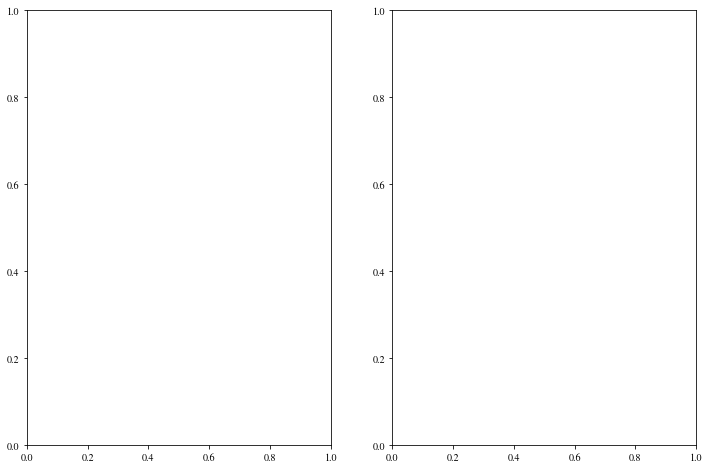

In [29]:
fig = plt.figure(figsize=(12,8),facecolor=(1, 1, 1)) #(12,8)

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

In [237]:
# Sort target_list
target_list = sorted(target_list, key=lambda v: (v[0]['p'],-v[0]['delta'],v[0]['gamma'],v[0]['k']))

# Basic settings
ub = 0.4
trim = True
sparselabel = True #0, 3, 7... 만 label 부여
save = True


if algorithm=='noisy':
    colors = pl.cm.viridis(np.linspace(0,0.8,len(target_list)))
elif algorithm=='oja':
    colors = pl.cm.plasma(np.linspace(0,0.85,len(target_list)))
    
else:
    raise NotImplementedError

# Main
for c, (hyperdict, datadict_list) in enumerate(target_list):
    
    if algorithm=='noisy':
        lp_xaxis = np.copy(noisy_param_list)#[1:-3]
    elif algorithm=='oja':
        lp_xaxis = np.copy(oja_param_list)#[:-2]
        #lp_xaxis = np.flip(lp_xaxis)

    # Extract Data
    dist_array = np.zeros((loop,len(lp_xaxis)))    
    for repeat,datadict in enumerate(datadict_list):

        for lp_idx,lp in enumerate(lp_xaxis):
            if algorithm == 'oja':
                dist_array[repeat,lp_idx] = np.average(datadict[lp][-30:])  
            else:
                dist_array[repeat,lp_idx] = np.average(datadict[lp][len(datadict[lp])//3:])
    
    #dist_array = np.flip(dist_array,axis=1) if algo=='oja' else dist_array
    
    # Set Label
    #label_str = r'$(\Gamma,\delta,p)=({:.0e},{:.1f},{})$'.format(hyperdict['gamma'],hyperdict['delta'],hyperdict['p'])
    label_str = r'$\Gamma={:.0e}$'.format(hyperdict['gamma'])
        
    avg = np.average(dist_array,axis=0)
    std = np.std(dist_array,axis=0)
    
    # Trim unconverged data
    
    if trim and algorithm=='oja':
        if np.where(avg<ub)[0].size != 0:
            args = np.where(avg<ub)[0]
            print(args)
            lp_xaxis = lp_xaxis[args]
            avg, std = avg[args], std[args]
            
    avg = avg * np.sqrt(lp_xaxis)
    #avg = avg / lp_xaxis
        
    # Plot line
    if sparselabel:
        label_str = label_str if c%4==1 else '_nolegend_'
    
    ax1.plot(lp_xaxis,avg,ls='--',linewidth=2,color=colors[c],label=label_str,zorder=1)
    #plt.errorbar(lp_xaxis,avg,std,fmt='none', ecolor=colors[c],elinewidth=2,capsize=0,zorder=2)
    
    # Plot marker 
    signlist = np.ones(len(lp_xaxis))
    arg = np.argmin(avg)
    
    signlist[arg+1:] = -1
    for jdx, sign in enumerate(signlist):
        sign = 1
        marker_s = ('o',100) if sign==1 else ('o',75)
        color_s   = ('none',colors[c]) if sign==1 else (colors[c],'white')
        ax1.scatter(lp_xaxis[jdx],avg[jdx],marker=marker_s[0],s=marker_s[1],\
                    color=color_s[1],edgecolors=color_s[0],linewidths=2,zorder=3) 

# Title
algoname = 'Oja\'s Algorithm' if algorithm=='oja' else 'Noisy Power Method'
if paramtitle:
    title = algoname + r', $(\delta,\,\sigma,\,p/k)=({:.1f},\,{:.2f},\,{:d})$'.format(delta, sigma, p//k)
    titlesize = 28
else:
    title = algoname
    titlesize = 40
ax1.set_title(title,fontsize=titlesize,pad=20)

# Other plotting details

# for 'npm_k2_noisy'
if algorithm=='noisy':
    ax1.set_xlabel(r'Block Size $B$',fontsize=28,labelpad=5)
    ax1.set_xlim(10,12000) # -500, 10000
    ax1.set_ylim(0.00,20.0)  # 20.0 0.0001
    ax1.set_xticks([100,1000,10000])
    ax1.set_yticks([5,10,15,20])
    ax1.set_xticklabels([r'$10^{2}$',r'$10^{3}$',r'$10^{4}$'],fontsize=24)
    ax1.set_yticklabels([r'$5$',r'$10$',r'$15$',r'$20$'],fontsize=24)
    ax1.set_xscale("log")

elif algorithm=='oja':
    ax1.set_xlabel(r'Learning rate $\zeta$',fontsize=28,labelpad=5)
    ax1.set_xlim(1/20000,1/0.9)
    ax1.set_xticks([1.0e-4,1.0e-3,1.0e-2,1.0e-1,1.0],fontsize=24)
    ax1.set_ylim(0.00,ub*1.05)
    ax1.set_yticks(fontsize=24)
    ax1.gca().invert_xaxis()
    ax1.set_xscale("log")
    
else:
    raise NotImplementedError

ax1.set_ylabel(r'$||\,U_{k\!\!+\!\!1\!:\!p}\,\,{\hat{U}_{1\!:\!k}^{\,\top}}\,||_2$',fontsize=24)

fig.legend(loc="center right",fontsize=20,frameon=False,ncol=1)
fig.tight_layout()
fig.savefig('./order',dpi=dpi)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


TypeError: set_ticks() got an unexpected keyword argument 'fontsize'

## Convergence Graph

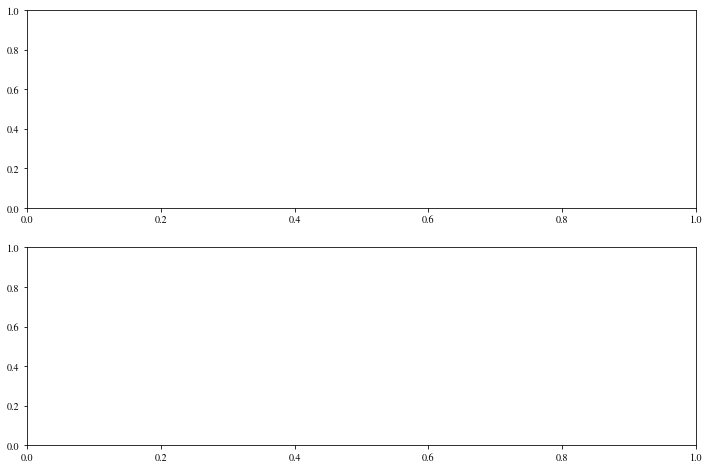

In [57]:
fig = plt.figure(figsize=(12,8),facecolor=(1, 1, 1)) #(12,8)

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

In [61]:
if algorithm == 'noisy':
    ax = ax1
else:
    ax = ax2

target_list = sorted(target_list, key=lambda v: (v[0]['p'],-v[0]['delta'],v[0]['gamma'],v[0]['k']))

nnn = -5

smoothing = False
smoothing_str = '' if smoothing else '_nosmooth'
save = True
sparselabel = True

datadict_list = target_list[nnn][1]
gamma = target_list[nnn][0]['gamma']
delta = target_list[nnn][0]['delta']
print('gamma',gamma)
print('delta',delta)

if algorithm == 'oja':
    titlestr = 'Oja\'s Algorithm'
    _learning_param_list = oja_param_list[10:]
    colors = pl.cm.bone(np.linspace(0,0.85,len(_learning_param_list)))
else:
    titlestr = 'Noisy Power Method'
    _learning_param_list = noisy_param_list[10:]
    colors = pl.cm.copper(np.linspace(0,0.8,len(_learning_param_list)))
    

if paramtitle:
    title = titlestr +  r', $(\delta,\,\sigma,\,p/k,\,\Gamma)$'+r'$=({:.1f},\,{:.2f},\,{:d},\,{:.3f})$'.format(delta, sigma, p//k, gamma)
    titlesize = 28
else:
    title = titlestr
    titlesize = 44
ax.set_title(title,fontsize=titlesize,pad=20)
    
for c, lp in enumerate(_learning_param_list):
    
    grid = T_save if algorithm=='oja' else lp
    x = np.arange(T//grid + 1) * grid
    y = 0
    for datadict in datadict_list:
        yhat = datadict[lp]
        y += np.asarray(yhat)
        break
        
    #y /= loop
    
    if len(y) > 24 and smoothing:
        N =  3
        yconv = np.convolve(y, np.ones(N)/N, mode='valid')
        y[(N-1)//2:-(N-1)//2] = yconv
        
    if algorithm == 'oja':
        label_str = r'$\eta$={:.1e}'.format(lp)
    else:
        label_str = 'B={}'.format(lp)
        
    if sparselabel:
        label_str = label_str if c%3==0 else '_nolegend_'
    
    ax.plot(x,y, linewidth=1.5, color=colors[c],label=label_str)
        
    #print(lp,np.std(y[len(y)//4:]))

ax.set_xlim(1,T)
ax.set_ylim(0.0,1.01)

ax.set_xlabel(r'Time step $t$',fontsize=32,labelpad=5)
ax.set_ylabel(r'$||\,U_{k\!\!+\!\!1\!:\!p}\,\,{\hat{U}_{1\!:\!k}^{\,\top}}\,||_2$',fontsize=32)
ax.set_xticks([25000,50000,75000,100000,125000])
ax.set_yticks([0.0,0.50,1.0])
ax.set_xticklabels([25000,50000,75000,100000,125000],fontsize=28)
ax.set_yticklabels(['0.0','0.5','1.0'],fontsize=28)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False,fontsize=24)
plt.show()

gamma 3e-05
delta 1.0


In [62]:
fig.subplots_adjust(right=0.80)
fig.tight_layout()
fig.savefig('./series.eps',dpi=dpi)
fig.savefig('./series.png',dpi=dpi)

# E.O.D